In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from iris import irisRequests
import ngl
import datetime
from numba import njit
from numba.typed import Dict
from sklearn.metrics.pairwise import haversine_distances

In [13]:
@njit
def construct_aftershocks_map(region, coords, dlat, dlon):
    N_lat = int((region[1]-region[0])/dlat)
    N_lon = int((region[3]-region[2])/dlon)
    shocks_map = np.zeros((N_lat, N_lon))
    for coord in coords:
        i,j = int((coord[0]-region[0])/dlat), int((coord[1]-region[2])/dlon)
        shocks_map[i,j] += 1
    return shocks_map

In [ ]:
rootpath = "csv_24/"

In [ ]:
regions = {}
regions['japan'] = (20, 50, 120, 150)
regions['italy'] = (35,46,6, 19)

In [ ]:
station_list = ngl.ngl_process_list(ngl.ngl_24h_2w) # daily measurements, with 2 weeks delay

In [ ]:
station_info = {}
for name, region in regions.items():
    station_names, station_lats, station_lons  = ngl.get_all_stations_box(station_list, *region)
    station_info[name]= (station_names, station_lats, station_lons)

In [ ]:
station_data = {}
for name, s_info in station_info.items():
    for s_cnt, s_name in enumerate(s_info[0]):
        df, status = ngl.ngl_retrieve_24h(rootpath, s_name)
        print(s_name, status)
        station_data[s_name] = df

In [ ]:
start_time = datetime.datetime(2000, 1, 1, 0, 0, 0)
end_time =  datetime.datetime(2024, 1, 1, 0, 0, 0)
catalogs = {}
for name, region in regions.items():
    download_url =irisRequests.url_events_box(start_time, end_time, region[0], region[1], region[2], region[3], minmag=4, magtype="MW")
    df = pd.read_csv(download_url, sep="|", comment="#", parse_dates=["Time"])
    df.sort_values(by="Time", inplace=True)
    df.reset_index(inplace=True, drop=True)
    catalogs[name] = df

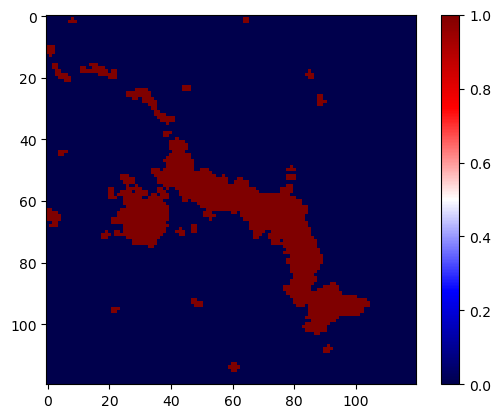

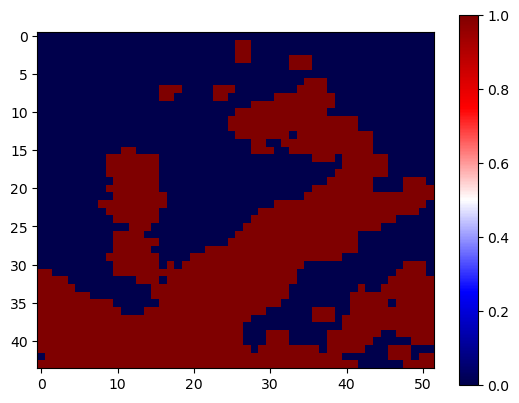

In [51]:
earthquakes = {}
maximal_time_shift = np.timedelta64(7, 'D')
minimal_time_shift = np.timedelta64(1, 'D')
dlat = 0.25
dlon = 0.25
for name, catalog in catalogs.items():
    # discretization of the region
    region = regions[name]
    N_lat = int((region[1]-region[0])/dlat)
    N_lon = int((region[3]-region[2])/dlon)
    grid_latlat, grid_lonlon = np.meshgrid( region[0] + np.arange(0, N_lat)*dlat, region[2] + np.arange(0, N_lon)*dlon, indexing='ij')
    grid_latlat = grid_latlat.flatten()
    grid_lonlon = grid_lonlon.flatten()
    grid = np.hstack([grid_latlat[:,None], grid_lonlon[:,None]])
    stations_coords = np.hstack([station_info[name][1][:,None], station_info[name][2][:,None]])
    grid_stations_dists = haversine_distances(np.radians(grid), np.radians(stations_coords))
    grid_stations_dists = grid_stations_dists.reshape((N_lat, N_lon, -1))
    plt.imshow(np.heaviside(0.005-grid_stations_dists.min(axis=-1),0), cmap='seismic')
    plt.colorbar()
    plt.show()
    # earthquakes identification
    large_shocks = catalog[catalog.Magnitude >= 6]
    large_shocks_days = large_shocks.Time
    large_shocks_coords =  large_shocks[['Latitude','Longitude']].values
    for day, coord in zip(large_shocks_days, large_shocks_coords):
        aftershocks = catalog[(catalog.Time >= day + minimal_time_shift)*(catalog.Time <= day +maximal_time_shift ) ]
        aftershocks_coords = aftershocks[['Latitude','Longitude']].values
        aftershocks_map = construct_aftershocks_map(region, aftershocks_coords, dlat, dlon)
    